In [1]:
import os
import zipfile
import tvm
import mxnet as mx
import cv2
import numpy as np
import nnvm
from nnvm import compiler
from nnvm.frontend import from_mxnet
from tvm.contrib.download import download
from tvm.contrib import graph_runtime
from mxnet.model import load_checkpoint
from mxnet import gluon
from mxnet import ndarray as nd

/home/wk/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sym,arg_params,aux_params = load_checkpoint("./original_deploy_ssd/deploy_ssd_mobilenet_v2_512",236)

In [3]:
net,params = from_mxnet(sym,arg_params,aux_params)

In [4]:
# target = tvm.target.current_target()
dshape = (1, 3, 512, 512)
dtype = "float32"


In [5]:
##build use arm_cpu
# target = tvm.target.arm_cpu('rasp3b')
    # The above line is a simple form of
# target1 = tvm.target.create('llvm -devcie=arm_cpu -model=bcm2837 -target=armv7l-linux-gnueabihf -mattr=+neon')
target = "llvm"
with nnvm.compiler.build_config(opt_level=3):
    graph, lib, params = nnvm.compiler.build(net, target, shape={"data": dshape}, params=params)

Cannot find config for target=llvm, workload=('conv2d', (1, 3, 512, 512, 'float32'), (32, 3, 3, 3, 'float32'), (2, 2), (1, 1), 'NCHW', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm, workload=('conv2d', (1, 32, 256, 256, 'float32'), (32, 32, 1, 1, 'float32'), (1, 1), (0, 0), 'NCHW', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm, workload=('conv2d', (1, 32, 256, 256, 'float32'), (16, 32, 1, 1, 'float32'), (1, 1), (0, 0), 'NCHW', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm, workload=('conv2d', (1, 16, 256, 256, 'float32'), (96, 16, 1, 1, 'float32'), (1, 1), (0, 0), 'NCHW', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm, workload=('conv2d', (1, 96, 128, 128, 'float32'), 

In [7]:
# save param for pi
# lib.export_library('./mobilenetv2_tvm_pi_IR/'+'mobilenetv2SSD_pi.tar')

In [26]:
### only save .so used cross compile
# pi_compiler_path = "/home/wk/wk_ws/tools/raspberry_tools/arm-bcm2708/gcc-linaro-arm-linux-gnueabihf-raspbian-x64/bin/arm-linux-gnueabihf-g++"
# lib.export_library('./mobilenetv2_tvm_pi_IR/'+'mv2_ssd.so',tvm.contrib.cc.create_shared,cc=pi_compiler_path)


In [6]:
## test save .so used x86 compiler and vertify tvm_runtime.so as c++ project
# pi_compiler_path = "/usr/bin/g++"
# lib.export_library('./x86_m2ssd/'+"x86_m2ssd.so",tvm.contrib.cc.create_shared,cc=pi_compiler_path)
# with open('./x86_m2ssd/'+'x86_m2ssd.json','w') as f:
#     f.write(graph.json())
# f.close()
# with open('./x86_m2ssd/'+'x86_m2ssd.params','wb') as f:
#     f.write(nnvm.compiler.save_param_dict(params))
# f.close()

In [8]:
with open('./mobilenetv2_tvm_pi_IR/'+'mobilenetv2SSD_pi.json','w') as f:
    f.write(graph.json())
f.close()
with open('./mobilenetv2_tvm_pi_IR/'+'mobilenetv2SSD_pi.params','wb') as f:
    f.write(nnvm.compiler.save_param_dict(params))
f.close()

### load params

In [9]:
#load param
loaded_json = open('./mobilenetv2_tvm_pi_IR/'+'mobilenetv2SSD_pi.json').read()
loaded_params = bytearray(open('./mobilenetv2_tvm_pi_IR/'+'mobilenetv2SSD_pi.params',"rb").read())
# loaded_lib = tvm.module.load('./ssd_model/'+'ssd_deploy_lib.tar')

In [16]:
from tvm import rpc
host = '192.168.201.50' # 
port = 9090
remote = rpc.connect(host, port)

In [17]:
remote.upload('./mobilenetv2_tvm_pi_IR/'+'mobilenetv2SSD_pi.tar')
rlib = remote.load_module('mobilenetv2SSD_pi.tar')

In [18]:
test_image_path = './test.jpg'
# Preprocess image
image = cv2.imread(test_image_path)
img_data = cv2.resize(image, (dshape[2], dshape[3]))
img_data = img_data[:, :, (2, 1, 0)].astype(np.float32)
img_data -= np.array([123, 117, 104])
img_data = np.transpose(np.array(img_data), (2, 0, 1))
img_data = np.expand_dims(img_data, axis=0)

(1, 3, 512, 512)

In [25]:
# create the remote runtime module
ctx = remote.cpu(0)
#-----
# module = graph_runtime.create(loaded_json, rlib, ctx) # used by load param
# module.load_params(loaded_params)
# use by nnvm cpmpiler
module = graph_runtime.create(graph.json(), rlib, ctx)
module.set_input(**params)
module.set_input('data', tvm.nd.array(img_data.astype('float32')))
import time
start = time.time()
# module.run(data=tvm.nd.array(img_data.astype(dtype)))
module.run()
#----
# get output
out1 = module.get_output(0)
# get top1 result
# top11 = np.argmax(out1.asnumpy())
# print('TVM prediction top-1: {}'.format(synset[top11]))
print(time.time()-start)

3.6828701496124268


In [21]:
class_names = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair",
               "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant",
               "sheep", "sofa", "train", "tvmonitor"]
def display(img, out, thresh=0.5):
    import random
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    mpl.rcParams['figure.figsize'] = (10,10)
    pens = dict()
    plt.clf()
    plt.imshow(img)
    for det in out:
        cid = int(det[0])
        if cid < 0:
            continue
        score = det[1]
        if score < thresh:
            continue
        if cid not in pens:
            pens[cid] = (random.random(), random.random(), random.random())
        scales = [img.shape[1], img.shape[0]] * 2
        xmin, ymin, xmax, ymax = [int(p * s) for p, s in zip(det[2:6].tolist(), scales)]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False,
                             edgecolor=pens[cid], linewidth=3)
        plt.gca().add_patch(rect)
        text = class_names[cid]
        plt.gca().text(xmin, ymin-2, '{:s} {:.3f}'.format(text, score),
                       bbox=dict(facecolor=pens[cid], alpha=0.5),
                       fontsize=12, color='white')
    plt.show()
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

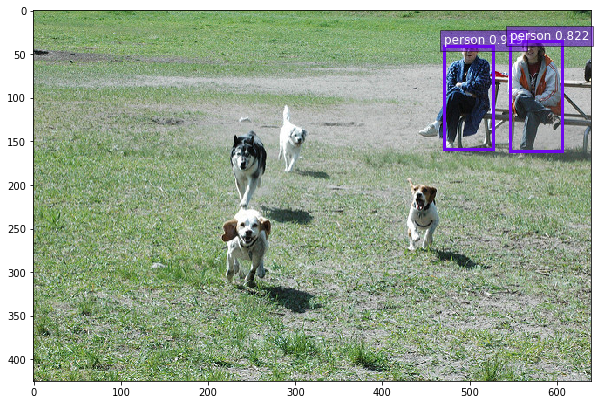

In [24]:
display(image, out1.asnumpy()[0], thresh=0.55)